# Analysis of interesting municipalities

## Importing libraries and appending paths

In [1]:
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import sys
import plotly.graph_objects as go

In [2]:
sys.path.append('..')

## Importing serotype data for year and municipality

In [3]:
file_s = '../Data/dengue_BR_serotypes.csv'
s_data = pd.read_csv(file_s, delimiter = ';')
s_data = s_data.drop(columns = ['Unnamed: 0', 'SG_UF_NOT'])

## Importing population data 

In [4]:
file_p = '../Data/PopMun/population_municipalities.csv'
p_data = pd.read_csv(file_p, delimiter = ';')

# Simultaneous analysis of municipalities

## Selecting municipalities of interests
- Regions that have a lot of cases, and perform a lot of tests for serotypes a year. All of them perform at least a few a years, there are very few municipalities who do this, most have skipped some years of testing for serotypes. In this case, SP is one that has done this, but due to its high volume of tests and cases/tests in most of the years I have included it.

In [5]:
municipalities = [355030, 330455, 520870, 530010, 230440, 310620, 354340, 354980]
names = ['SP','RJ','Goiania','DF','Fortaleza','Belo Horizonte', 'Rib. Preto', 'SJ do Rio Preto']
dict_mun_names = {municipalities[i]: names[i] for i in range(len(municipalities))}

In [6]:
s_data = s_data[s_data['ID_MUNICIP'].isin(municipalities)]

## Padding data for processing

In [7]:
years = s_data['YEAR'].unique()
muns = s_data['ID_MUNICIP'].unique()
serotypes = s_data['SOROTIPO'].unique()

In [8]:
years_df = []
muns_df = []
serotypes_df = []
cases_df = []

In [9]:
for year in years:
    for mun in muns:
        for serotype in serotypes:
            years_df.append(year)
            muns_df.append(mun)
            serotypes_df.append(serotype)
            filt_tmp = ((s_data['ID_MUNICIP'] == mun) & (s_data['YEAR'] == year) & (s_data['SOROTIPO'] == serotype))
            s_tmp = s_data[filt_tmp]
            if(s_tmp.empty):
                cases_df.append(0)
            else:
                cases_df.append(s_tmp.iloc[0]['NUMBER'])

In [10]:
df_total = pd.DataFrame(list(zip(years_df, muns_df, serotypes_df, cases_df)),
                   columns =['YEAR', 'ID_MUNICIP', 'SEROTYPE', 'CASES'])

## Calculation of total cases for each municipality and each year

In [11]:
df_cases = df_total.groupby(['YEAR','ID_MUNICIP'])['CASES'].sum()
df_cases = df_cases.to_frame(name = 'CASES').reset_index()

In [12]:
df_cases['ID_MUNICIP'] = df_cases['ID_MUNICIP'].astype(str)
muns = df_cases['ID_MUNICIP'].unique()

In [13]:
# adding population for each municipality and each year, iterating over row of df_cases
pop_tmp = []
for i in range(df_cases.shape[0]):
    year = df_cases.iloc[i,0]
    municipality = int(df_cases.iloc[i,1])
    p_tmp = p_data[p_data['Municipio'] == municipality][str(year)]
    pop_tmp.append(p_tmp.iloc[0])

In [14]:
df_cases['POPULATION'] = pop_tmp

In [15]:
df_cases['CASES/100POP'] = (10**5)*(df_cases['CASES']/df_cases['POPULATION'])

In [16]:
df_cases['CASES/POP'] = (df_cases['CASES']/df_cases['POPULATION'])

## Calculation of tests in each municipality and each year 

In [17]:
# total tests per state per year
df_res = df_total.copy()
filt_res = (df_res['SEROTYPE'] != ' ')
df_res = df_res[filt_res]
df_res = df_res.groupby(['YEAR','ID_MUNICIP'])['CASES'].sum()
df_res = df_res.to_frame(name = 'TESTS').reset_index()
df_res['CASES'] = df_cases['CASES']
df_res['POPULATION'] = df_cases['POPULATION']
df_res['TESTS/POP'] = (df_res['TESTS']/df_res['POPULATION'])
df_res['TESTS/100POP'] = (10**5)*(df_res['TESTS']/df_res['POPULATION'])
df_res['ID_MUNICIP'] = df_res['ID_MUNICIP'].astype(str)

# Cases and tests municipalities analysis 

## Cases in each municipality in each year, time series plots, population averages

### Total Cases

In [18]:
#extract color palette, the palette can be changed
pal = list(sns.color_palette(palette='plasma', n_colors=len(muns)).as_hex())

fig = go.Figure()
for d,p in zip(muns, pal):
    fig.add_trace(go.Scatter(x = df_cases[df_cases['ID_MUNICIP']==d]['YEAR'],
                             y = df_cases[df_cases['ID_MUNICIP']==d]['CASES'],
                             name = dict_mun_names[int(d)],
                             line_color = p, 
                             line_width = 4,
                             marker_size = 8,
                             fill=None))   #tozeroy 
    fig.update_layout(width = 900, height = 700)

fig.show()

### Total cases per 100 thousand inhabitants 

In [19]:
#extract color palette, the palette can be changed
pal = list(sns.color_palette(palette='plasma', n_colors=len(muns)).as_hex())

fig = go.Figure()
for d,p in zip(muns, pal):
    fig.add_trace(go.Scatter(x = df_cases[df_cases['ID_MUNICIP']==d]['YEAR'],
                             y = df_cases[df_cases['ID_MUNICIP']==d]['CASES/100POP'],
                             name = dict_mun_names[int(d)],
                             line_color = p, 
                             line_width = 4,
                             marker_size = 8,
                             fill=None))   #tozeroy 
    fig.update_layout(width = 900, height = 700)

fig.show()

# Tests in each municipality in each year, time series plots, population averages

### Total tests 

In [20]:
#extract color palette, the palette can be changed
pal = list(sns.color_palette(palette='plasma', n_colors=len(muns)).as_hex())

fig = go.Figure()
for d,p in zip(muns, pal):
    fig.add_trace(go.Scatter(x = df_res[df_res['ID_MUNICIP']==d]['YEAR'],
                             y = df_res[df_res['ID_MUNICIP']==d]['TESTS'],
                             name = dict_mun_names[int(d)],
                             line_color = p, 
                             line_width = 4,
                             marker_size = 8,
                             fill=None))   #tozeroy 
    fig.update_layout(width = 900, height = 700)

fig.show()

### Total cases per 100 thousand inhabitants 

In [21]:
#extract color palette, the palette can be changed
pal = list(sns.color_palette(palette='plasma', n_colors=len(muns)).as_hex())

fig = go.Figure()
for d,p in zip(muns, pal):
    fig.add_trace(go.Scatter(x = df_res[df_res['ID_MUNICIP']==d]['YEAR'],
                             y = df_res[df_res['ID_MUNICIP']==d]['TESTS/100POP'],
                             name = dict_mun_names[int(d)],
                             line_color = p, 
                             line_width = 4,
                             marker_size = 8,
                             fill=None))   #tozeroy 
    fig.update_layout(width = 900, height = 700)

fig.show()

# Individual municipality analysis

## Municipality 1: Sao Paulo - serotypes

C:\Users\denis\AppData\Local\Temp\ipykernel_17640\2150332718.py:18: RuntimeWarning:

invalid value encountered in divide

C:\Users\denis\AppData\Local\Temp\ipykernel_17640\2150332718.py:19: RuntimeWarning:

invalid value encountered in divide

C:\Users\denis\AppData\Local\Temp\ipykernel_17640\2150332718.py:20: RuntimeWarning:

invalid value encountered in divide

C:\Users\denis\AppData\Local\Temp\ipykernel_17640\2150332718.py:21: RuntimeWarning:

invalid value encountered in divide



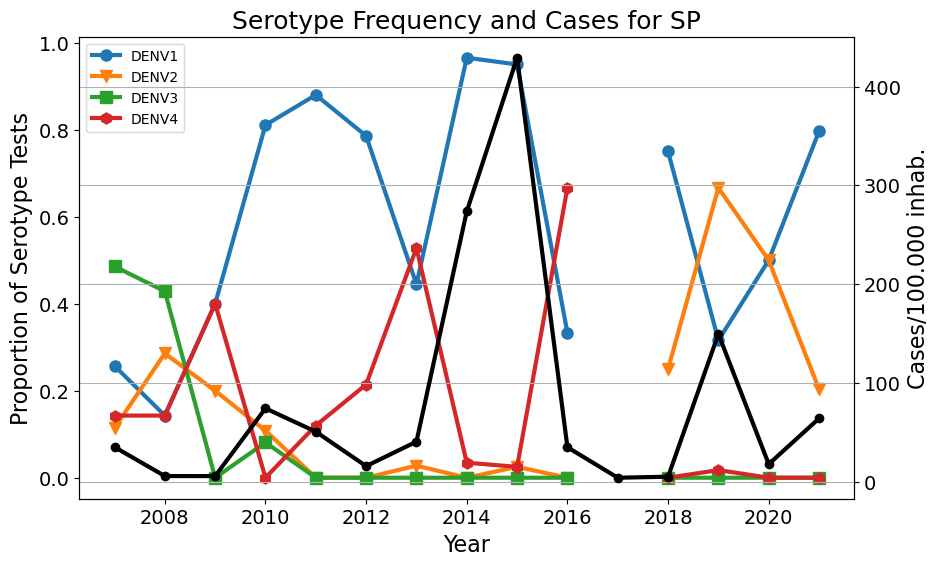

In [52]:
# cases of filtered municipality per serotype
id_municipality = 355030
df_sp = df_total[df_total['ID_MUNICIP'] == id_municipality]
df_sp = df_sp.drop(columns = ['ID_MUNICIP'])

# total cases of filtered municipality
df_sp_total = df_res[df_res['ID_MUNICIP'] == str(id_municipality)]
df_sp_total = (df_sp_total['CASES']/df_sp_total['POPULATION'])
df_sp_total = df_sp_total.to_numpy()

# total tests of filtered municipality 
df_sp_tests = df_res[df_res['ID_MUNICIP'] == str(id_municipality)]
df_sp_tests = df_sp_tests['TESTS']
df_sp_tests = df_sp_tests.to_numpy()


fig, ax1 = plt.subplots(figsize = (10,6))
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='1']['CASES'].to_numpy()/df_sp_tests, '-o', label = 'DENV1', linewidth = 3, markersize = 8)
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='2']['CASES'].to_numpy()/df_sp_tests, '-v', label = 'DENV2', linewidth = 3, markersize = 8)
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='3']['CASES'].to_numpy()/df_sp_tests, '-s', label = 'DENV3', linewidth = 3,  markersize = 8)
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='4']['CASES'].to_numpy()/df_sp_tests, '-h', label = 'DENV4', linewidth = 3,  markersize = 8)
ax1.set_ylabel('Proportion of Serotype Tests',fontsize = 16)
ax1.set_xlabel('Year',fontsize = 16)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(df_sp['YEAR'].unique(),(10**5)*df_sp_total,'-ok', linewidth = 3)
ax2.set_ylabel('Cases/100.000 inhab.', fontsize = 16)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.grid()
plt.title('Serotype Frequency and Cases for '+dict_mun_names[int(id_municipality)], fontsize = 18)
plt.show()

## Municipality 2: Rio de Janeiro - serotypes

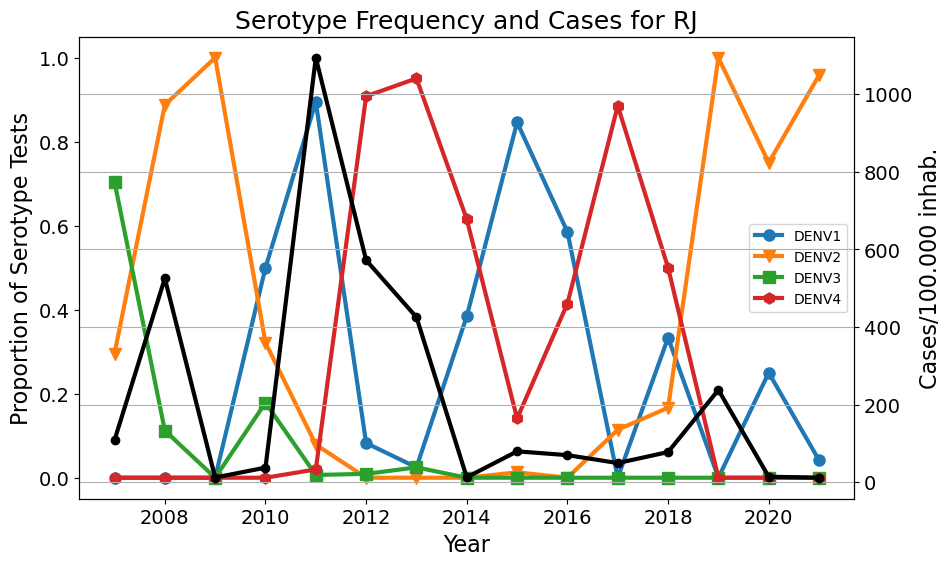

In [38]:
# cases of filtered municipality per serotype
id_municipality = 330455
df_sp = df_total[df_total['ID_MUNICIP'] == id_municipality]
df_sp = df_sp.drop(columns = ['ID_MUNICIP'])

# total cases of filtered municipality
df_sp_total = df_res[df_res['ID_MUNICIP'] == str(id_municipality)]
df_sp_total = (df_sp_total['CASES']/df_sp_total['POPULATION'])
df_sp_total = df_sp_total.to_numpy()

# total tests of filtered municipality 
df_sp_tests = df_res[df_res['ID_MUNICIP'] == str(id_municipality)]
df_sp_tests = df_sp_tests['TESTS']
df_sp_tests = df_sp_tests.to_numpy()


fig, ax1 = plt.subplots(figsize = (10,6))
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='1']['CASES'].to_numpy()/df_sp_tests, '-o', label = 'DENV1', linewidth = 3, markersize = 8)
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='2']['CASES'].to_numpy()/df_sp_tests, '-v', label = 'DENV2', linewidth = 3, markersize = 8)
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='3']['CASES'].to_numpy()/df_sp_tests, '-s', label = 'DENV3', linewidth = 3,  markersize = 8)
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='4']['CASES'].to_numpy()/df_sp_tests, '-h', label = 'DENV4', linewidth = 3,  markersize = 8)
ax1.set_ylabel('Proportion of Serotype Tests',fontsize = 16)
ax1.set_xlabel('Year',fontsize = 16)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(df_sp['YEAR'].unique(),(10**5)*df_sp_total,'-ok', linewidth = 3)
ax2.set_ylabel('Cases/100.000 inhab.', fontsize = 16)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.grid()
plt.title('Serotype Frequency and Cases for '+dict_mun_names[int(id_municipality)], fontsize = 18)
plt.show()

## Municipality 3: Goiania - serotypes

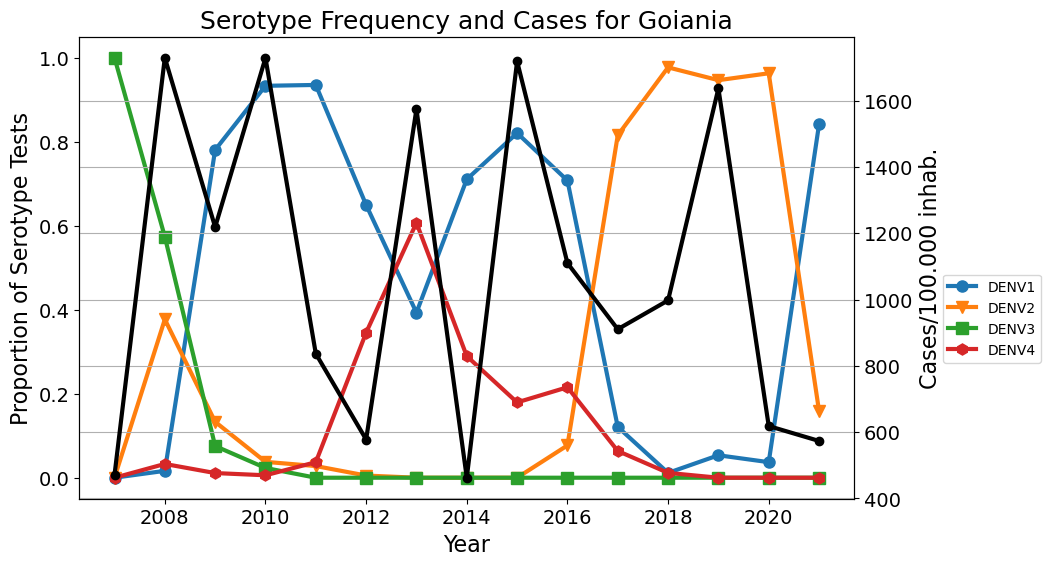

In [53]:
# cases of filtered municipality per serotype
id_municipality = 520870
df_sp = df_total[df_total['ID_MUNICIP'] == id_municipality]
df_sp = df_sp.drop(columns = ['ID_MUNICIP'])

# total cases of filtered municipality
df_sp_total = df_res[df_res['ID_MUNICIP'] == str(id_municipality)]
df_sp_total = (df_sp_total['CASES']/df_sp_total['POPULATION'])
df_sp_total = df_sp_total.to_numpy()

# total tests of filtered municipality 
df_sp_tests = df_res[df_res['ID_MUNICIP'] == str(id_municipality)]
df_sp_tests = df_sp_tests['TESTS']
df_sp_tests = df_sp_tests.to_numpy()


fig, ax1 = plt.subplots(figsize = (10,6))
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='1']['CASES'].to_numpy()/df_sp_tests, '-o', label = 'DENV1', linewidth = 3, markersize = 8)
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='2']['CASES'].to_numpy()/df_sp_tests, '-v', label = 'DENV2', linewidth = 3, markersize = 8)
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='3']['CASES'].to_numpy()/df_sp_tests, '-s', label = 'DENV3', linewidth = 3,  markersize = 8)
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='4']['CASES'].to_numpy()/df_sp_tests, '-h', label = 'DENV4', linewidth = 3,  markersize = 8)
ax1.set_ylabel('Proportion of Serotype Tests',fontsize = 16)
ax1.set_xlabel('Year',fontsize = 16)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.legend(bbox_to_anchor=(1.25, 0.5))
ax2 = ax1.twinx()
ax2.plot(df_sp['YEAR'].unique(),(10**5)*df_sp_total,'-ok', linewidth = 3)
ax2.set_ylabel('Cases/100.000 inhab.', fontsize = 16)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.grid()
plt.title('Serotype Frequency and Cases for '+dict_mun_names[int(id_municipality)], fontsize = 18)
plt.show()

## Municipality 4: Brasilia, DF - serotypes

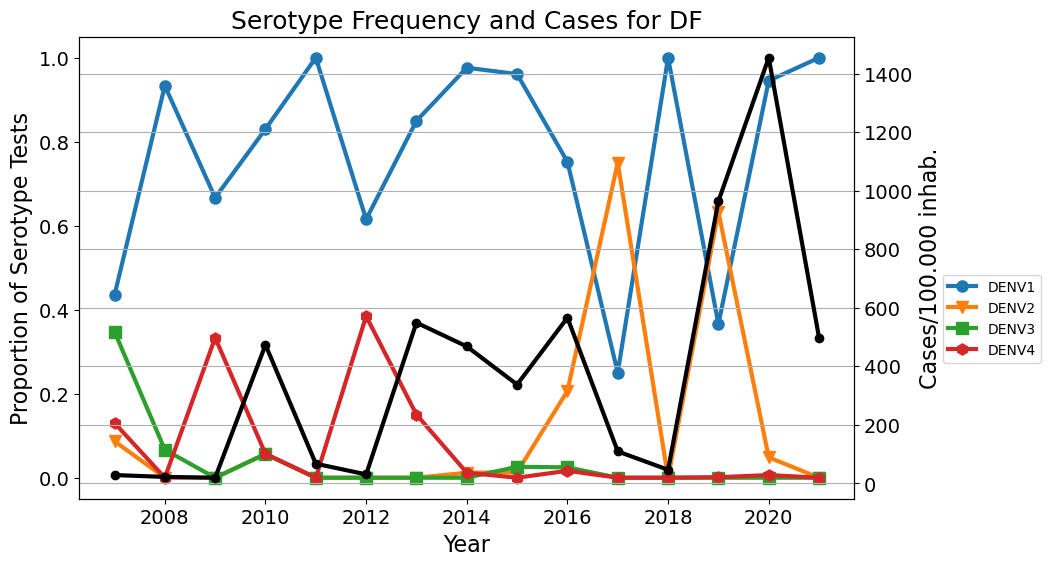

In [54]:
# cases of filtered municipality per serotype
id_municipality = 530010
df_sp = df_total[df_total['ID_MUNICIP'] == id_municipality]
df_sp = df_sp.drop(columns = ['ID_MUNICIP'])

# total cases of filtered municipality
df_sp_total = df_res[df_res['ID_MUNICIP'] == str(id_municipality)]
df_sp_total = (df_sp_total['CASES']/df_sp_total['POPULATION'])
df_sp_total = df_sp_total.to_numpy()

# total tests of filtered municipality 
df_sp_tests = df_res[df_res['ID_MUNICIP'] == str(id_municipality)]
df_sp_tests = df_sp_tests['TESTS']
df_sp_tests = df_sp_tests.to_numpy()


fig, ax1 = plt.subplots(figsize = (10,6))
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='1']['CASES'].to_numpy()/df_sp_tests, '-o', label = 'DENV1', linewidth = 3, markersize = 8)
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='2']['CASES'].to_numpy()/df_sp_tests, '-v', label = 'DENV2', linewidth = 3, markersize = 8)
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='3']['CASES'].to_numpy()/df_sp_tests, '-s', label = 'DENV3', linewidth = 3,  markersize = 8)
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='4']['CASES'].to_numpy()/df_sp_tests, '-h', label = 'DENV4', linewidth = 3,  markersize = 8)
ax1.set_ylabel('Proportion of Serotype Tests',fontsize = 16)
ax1.set_xlabel('Year',fontsize = 16)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.legend(bbox_to_anchor=(1.25, 0.5))
ax2 = ax1.twinx()
ax2.plot(df_sp['YEAR'].unique(),(10**5)*df_sp_total,'-ok', linewidth = 3)
ax2.set_ylabel('Cases/100.000 inhab.', fontsize = 16)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.grid()
plt.title('Serotype Frequency and Cases for '+dict_mun_names[int(id_municipality)], fontsize = 18)
plt.show()

## Municipality 5: Fortaleza, CE - serotypes

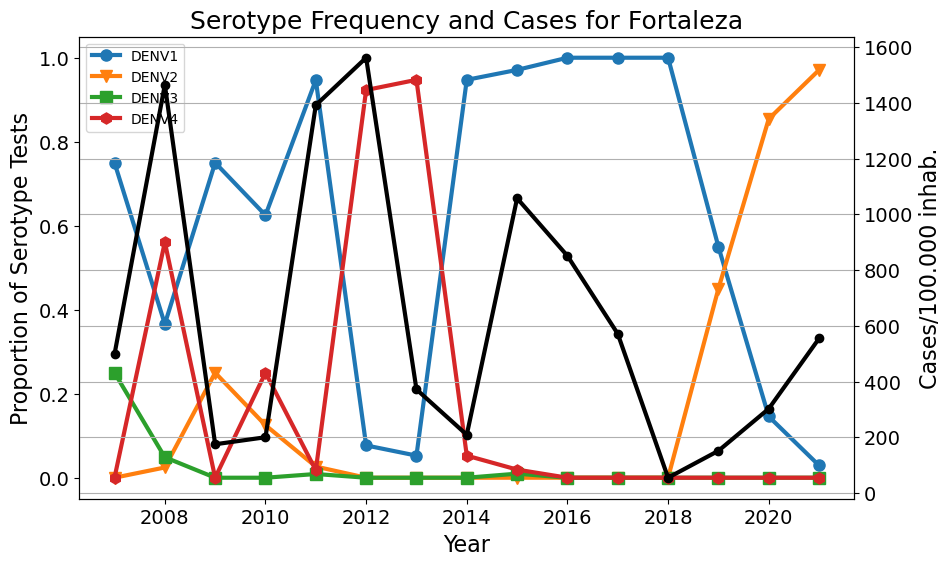

In [41]:
# cases of filtered municipality per serotype
id_municipality = 230440
df_sp = df_total[df_total['ID_MUNICIP'] == id_municipality]
df_sp = df_sp.drop(columns = ['ID_MUNICIP'])

# total cases of filtered municipality
df_sp_total = df_res[df_res['ID_MUNICIP'] == str(id_municipality)]
df_sp_total = (df_sp_total['CASES']/df_sp_total['POPULATION'])
df_sp_total = df_sp_total.to_numpy()

# total tests of filtered municipality 
df_sp_tests = df_res[df_res['ID_MUNICIP'] == str(id_municipality)]
df_sp_tests = df_sp_tests['TESTS']
df_sp_tests = df_sp_tests.to_numpy()


fig, ax1 = plt.subplots(figsize = (10,6))
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='1']['CASES'].to_numpy()/df_sp_tests, '-o', label = 'DENV1', linewidth = 3, markersize = 8)
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='2']['CASES'].to_numpy()/df_sp_tests, '-v', label = 'DENV2', linewidth = 3, markersize = 8)
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='3']['CASES'].to_numpy()/df_sp_tests, '-s', label = 'DENV3', linewidth = 3,  markersize = 8)
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='4']['CASES'].to_numpy()/df_sp_tests, '-h', label = 'DENV4', linewidth = 3,  markersize = 8)
ax1.set_ylabel('Proportion of Serotype Tests',fontsize = 16)
ax1.set_xlabel('Year',fontsize = 16)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(df_sp['YEAR'].unique(),(10**5)*df_sp_total,'-ok', linewidth = 3)
ax2.set_ylabel('Cases/100.000 inhab.', fontsize = 16)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.grid()
plt.title('Serotype Frequency and Cases for '+dict_mun_names[int(id_municipality)], fontsize = 18)
plt.show()

## Municipality 7: Belo Horizonte, MG - serotypes

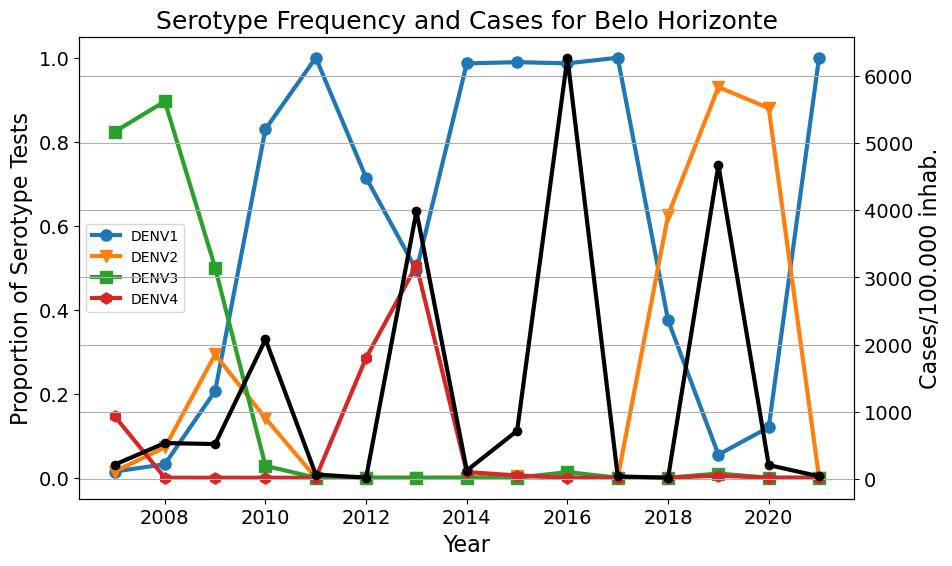

In [42]:
# cases of filtered municipality per serotype
id_municipality = 310620
df_sp = df_total[df_total['ID_MUNICIP'] == id_municipality]
df_sp = df_sp.drop(columns = ['ID_MUNICIP'])

# total cases of filtered municipality
df_sp_total = df_res[df_res['ID_MUNICIP'] == str(id_municipality)]
df_sp_total = (df_sp_total['CASES']/df_sp_total['POPULATION'])
df_sp_total = df_sp_total.to_numpy()

# total tests of filtered municipality 
df_sp_tests = df_res[df_res['ID_MUNICIP'] == str(id_municipality)]
df_sp_tests = df_sp_tests['TESTS']
df_sp_tests = df_sp_tests.to_numpy()


fig, ax1 = plt.subplots(figsize = (10,6))
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='1']['CASES'].to_numpy()/df_sp_tests, '-o', label = 'DENV1', linewidth = 3, markersize = 8)
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='2']['CASES'].to_numpy()/df_sp_tests, '-v', label = 'DENV2', linewidth = 3, markersize = 8)
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='3']['CASES'].to_numpy()/df_sp_tests, '-s', label = 'DENV3', linewidth = 3,  markersize = 8)
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='4']['CASES'].to_numpy()/df_sp_tests, '-h', label = 'DENV4', linewidth = 3,  markersize = 8)
ax1.set_ylabel('Proportion of Serotype Tests',fontsize = 16)
ax1.set_xlabel('Year',fontsize = 16)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(df_sp['YEAR'].unique(),(10**5)*df_sp_total,'-ok', linewidth = 3)
ax2.set_ylabel('Cases/100.000 inhab.', fontsize = 16)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.grid()
plt.title('Serotype Frequency and Cases for '+dict_mun_names[int(id_municipality)], fontsize = 18)
plt.show()

## Municipality 8: Riberao Preto, SP - serotypes

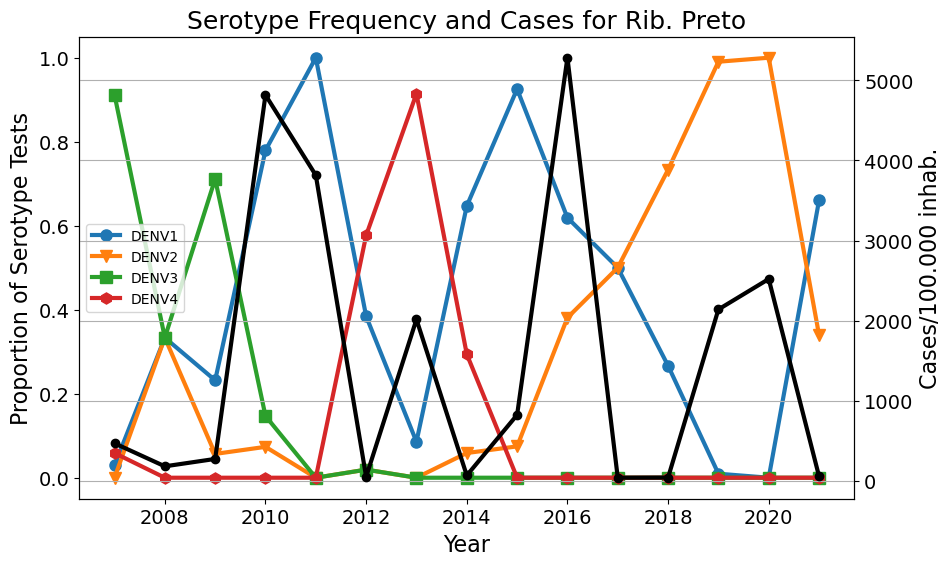

In [43]:
# cases of filtered municipality per serotype
id_municipality = 354340
df_sp = df_total[df_total['ID_MUNICIP'] == id_municipality]
df_sp = df_sp.drop(columns = ['ID_MUNICIP'])

# total cases of filtered municipality
df_sp_total = df_res[df_res['ID_MUNICIP'] == str(id_municipality)]
df_sp_total = (df_sp_total['CASES']/df_sp_total['POPULATION'])
df_sp_total = df_sp_total.to_numpy()

# total tests of filtered municipality 
df_sp_tests = df_res[df_res['ID_MUNICIP'] == str(id_municipality)]
df_sp_tests = df_sp_tests['TESTS']
df_sp_tests = df_sp_tests.to_numpy()


fig, ax1 = plt.subplots(figsize = (10,6))
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='1']['CASES'].to_numpy()/df_sp_tests, '-o', label = 'DENV1', linewidth = 3, markersize = 8)
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='2']['CASES'].to_numpy()/df_sp_tests, '-v', label = 'DENV2', linewidth = 3, markersize = 8)
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='3']['CASES'].to_numpy()/df_sp_tests, '-s', label = 'DENV3', linewidth = 3,  markersize = 8)
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='4']['CASES'].to_numpy()/df_sp_tests, '-h', label = 'DENV4', linewidth = 3,  markersize = 8)
ax1.set_ylabel('Proportion of Serotype Tests',fontsize = 16)
ax1.set_xlabel('Year',fontsize = 16)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(df_sp['YEAR'].unique(),(10**5)*df_sp_total,'-ok', linewidth = 3)
ax2.set_ylabel('Cases/100.000 inhab.', fontsize = 16)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.grid()
plt.title('Serotype Frequency and Cases for '+dict_mun_names[int(id_municipality)], fontsize = 18)
plt.show()

## Municipality 9: Sao José do Rio Preto - serotypes

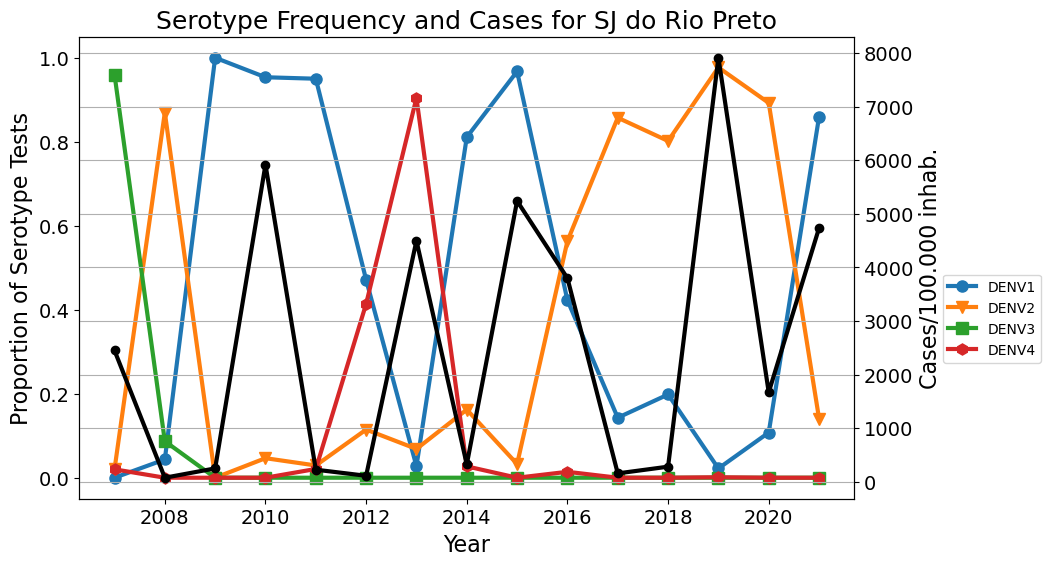

In [55]:
# cases of filtered municipality per serotype
id_municipality = 354980
df_sp = df_total[df_total['ID_MUNICIP'] == id_municipality]
df_sp = df_sp.drop(columns = ['ID_MUNICIP'])

# total cases of filtered municipality
df_sp_total = df_res[df_res['ID_MUNICIP'] == str(id_municipality)]
df_sp_total = (df_sp_total['CASES']/df_sp_total['POPULATION'])
df_sp_total = df_sp_total.to_numpy()

# total tests of filtered municipality 
df_sp_tests = df_res[df_res['ID_MUNICIP'] == str(id_municipality)]
df_sp_tests = df_sp_tests['TESTS']
df_sp_tests = df_sp_tests.to_numpy()


fig, ax1 = plt.subplots(figsize = (10,6))
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='1']['CASES'].to_numpy()/df_sp_tests, '-o', label = 'DENV1', linewidth = 3, markersize = 8)
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='2']['CASES'].to_numpy()/df_sp_tests, '-v', label = 'DENV2', linewidth = 3, markersize = 8)
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='3']['CASES'].to_numpy()/df_sp_tests, '-s', label = 'DENV3', linewidth = 3,  markersize = 8)
ax1.plot(df_sp['YEAR'].unique(),df_sp[df_sp['SEROTYPE']=='4']['CASES'].to_numpy()/df_sp_tests, '-h', label = 'DENV4', linewidth = 3,  markersize = 8)
ax1.set_ylabel('Proportion of Serotype Tests',fontsize = 16)
ax1.set_xlabel('Year',fontsize = 16)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.legend(bbox_to_anchor=(1.25, 0.5))
ax2 = ax1.twinx()
ax2.plot(df_sp['YEAR'].unique(),(10**5)*df_sp_total,'-ok', linewidth = 3)
ax2.set_ylabel('Cases/100.000 inhab.', fontsize = 16)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.grid()
plt.title('Serotype Frequency and Cases for '+dict_mun_names[int(id_municipality)], fontsize = 18)
plt.show()